In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import datetime
import random
import torch.nn.utils as utils
import uuid

Get Data

In [2]:
def get_data(path):
    image_extensions = ['.jpg']
    image_names = []
    for filename in os.listdir(path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

In [3]:
path = '/Users/ayanfe/Documents/Datasets/animefaces256cleaner'
model_path = '/Users/ayanfe/Documents/Code/Diffusion-Model/weights/waifu-diffusion-n-cts_1000-4000.pth'
image_names = get_data(path)
print("Image Length: ",len(image_names))

Image Length:  92219


In [4]:
timesteps = 1000


# create a fixed beta schedule
def linear():
    beta = np.linspace(0.0001, 0.02, timesteps)
    alpha = 1 - beta
    alpha_bar = np.cumprod(alpha, 0)
    alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
    sqrt_alpha_bar = np.sqrt(alpha_bar)
    one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)
    return sqrt_alpha_bar, one_minus_sqrt_alpha_bar

def cosine(t, timesteps=1000):
    min_signal_rate = 0.02
    max_signal_rate = 0.95

    # Ensure t is a float tensor
    t = t.float()
    
    # Normalize t by the number of timesteps
    #t = t / timesteps

    # Compute start and end angles using arccos, ensuring the computation stays within PyTorch
    start_angle = torch.arccos(torch.tensor([max_signal_rate], device=t.device))
    end_angle = torch.arccos(torch.tensor([min_signal_rate], device=t.device))
    
    # Calculate diffusion angles
    diffusion_angles = start_angle + t * (end_angle - start_angle)
    
    # Calculate signal and noise rates using PyTorch operations
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates
    
# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_linear_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar, one_minus_sqrt_alpha_bar = linear()
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * ((x_0 - 127.5)/127.5) + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

def forward_cosine_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    time = t/timesteps
    noise_rates,signal_rates = cosine(time)
    reshaped_noise_rates = np.reshape(noise_rates, (-1, 1, 1, 1))
    reshaped_signal_rates = np.reshape(signal_rates, (-1, 1, 1, 1))
    noisy_image = reshaped_signal_rates  * ((x_0 - 127.5)/127.5) + reshaped_noise_rates * noise
    return noisy_image, noise, noise_rates

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return torch.randint(0, timesteps,(num,), dtype=torch.int32)

def reshape_img(img,size = (32,32)):
    data = cv2.resize(img,size)
    data = np.transpose(data,(2,0,1))
    return data

def save_img(img,path):
    plt.imshow(np.transpose(img[-1].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')  # If you want to hide the axes
    # Generate a random filename
    random_filename = str(uuid.uuid4()) + '.png'

    # Specify the directory where you want to save the image
    save_directory = path

    # Create the full path including the directory and filename
    full_path = os.path.join(save_directory, random_filename)
    # Save the image with the random filename
    plt.savefig(full_path, bbox_inches='tight', pad_inches=0)

Visualize the output image at some timesteps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


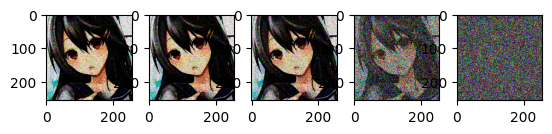

In [5]:
# Let us visualize the output image at a few timestamps
sample_data = plt.imread(path+'/'+image_names[0])

for index, i in enumerate([0,10, 50, 500, 999]):
    noisy_im, noise,_ = forward_cosine_noise(0, np.expand_dims(sample_data, 0), torch.from_numpy(np.array([i,])))
    plt.subplot(1, 5, index+1)
    plt.imshow(np.squeeze(noisy_im,0))
    
plt.show()

In [6]:
def ddim(x_t, pred_noise, t ,noise_rate, signal_rate, sigma_t):
    alpha_t_bar = signal_rate  # Cast t to integer before using np.take
    alpha_t_minus_one = noise_rate  # Similarly, cast t-1 to integer

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def inference(model, device, num_samples=5):
    # Define number of inference loops to run
    inference_timesteps = 30
    
    # Create a range of inference steps that the output should be sampled at
    inference_range = torch.flip(torch.linspace(0, timesteps-1, steps=inference_timesteps), dims=[0])
    
    x = torch.randn(1, 3, 64, 64).to(device)  # Initialize a random input image on GPU
    img_list = []
    img_list.append(np.squeeze(x.cpu().numpy(), 0))  # Append the initial image

    # Iterate over inference_timesteps
    for i in range(inference_timesteps):
        t = np.expand_dims(inference_range[i], 0)
        t = torch.from_numpy(t).type(torch.float32).to(device)
        t = torch.reshape(t, (-1, 1)).type(torch.float32)
        
        pred_noise = model(x, t/timesteps).detach().to(device)  # Obtain predicted noise
        noise_rates, signal_rates = cosine(t,timesteps = timesteps)
        x = ddim(x.cpu().detach().numpy(), pred_noise.cpu().detach().numpy(),t.cpu().detach().numpy(),
                 noise_rates.cpu().detach().numpy() ,signal_rates.cpu().detach().numpy() ,0)  # Perform denoising using DDIM
        x = torch.from_numpy(x).type(torch.float32).to(device)  # Transfer denoised image back to GPU
        img_list.append(np.squeeze(x.cpu().detach().numpy(), 0))  # Append the denoised image
    
    # Visualize the final denoised image
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [9]:
def reverse_diffusion(model, diffusion_steps, device='mps'):
    step_size = 1.0 / diffusion_steps
    current_images = torch.randn(1, 3, 64, 64).to(device)
    model.eval()
    with torch.no_grad():
        for step in range(diffusion_steps):
            diffusion_times = torch.ones((1, 1)).to(device) - step * step_size 

            # Ensure model and other  operations are also moved to the device
            noise_rates, signal_rates = cosine(diffusion_times.to("cpu"))
            pred_noises = model(current_images, diffusion_times.to(device))
            save_img(pred_noises,'Noise/')
            
            pred_noises = pred_noises.to(device)  # Move to the specified device
            noise_rates = noise_rates.to(device)  # Move to the specified device
            signal_rates = signal_rates.to(device)  # Move to the specified device
            
            pred_images = (current_images - noise_rates * pred_noises) / signal_rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = cosine(next_diffusion_times.to("cpu"))
            
            next_noise_rates = next_noise_rates.to(device)  # Move to the specified device
            next_signal_rates = next_signal_rates.to(device)  # Move to the specified device

            #save_img(pred_images,'Inference Steps/')
            
            current_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
    model.train()
    pred_images = (pred_images.clamp(-1, 1) + 1) / 2
    
    # Detach the tensor before converting it to a NumPy array
    plt.imshow(np.transpose(pred_images[-1].cpu().numpy(), (1, 2, 0)))
    plt.show()


In [10]:
start = 1
img_length = len(image_names)
data_length = 5200
data_idx = list(range(0,data_length+32))
random.shuffle(data_idx)

def training_loop(n_epochs, optimizer, model, loss_fn, device, accumulation_steps=1, 
                  epoch_start = 0, batch_size = 64, max_grad_norm=1.0, repeats = 5, timesteps = 200):
    global start
    with torch.autograd.set_detect_anomaly(True):
        for epoch in range(epoch_start, n_epochs + 1):
            loss_train = 0.0
            accumulated_loss = 0.0
            loss_mae = 0.0
            random.shuffle(data_idx)
            # Use tqdm function for the progress bar
            with tqdm(range(start, (repeats*data_length)//batch_size), desc=f'Epoch {epoch}', unit=' steps') as pbar:
                st = 0
                for x in pbar:
                    # Training loop code
                    sp = st + batch_size
                    if sp > data_length:
                        st = 0
                        sp = st + batch_size
                    img_arr = []
                    for i in range(st,sp):
                        img = plt.imread(path + '/' + image_names[data_idx[i]])
                        img = reshape_img(img)
                        img = np.expand_dims(img, 0)
                        img_arr.append(img)
                    st+= batch_size
                    
                    t = generate_timestamp(None, batch_size)
                    t = torch.reshape(t, (-1, 1)).type(torch.float32)
                    t /= timesteps
                    
                    imgs, noise, noise_rates = forward_cosine_noise(None, np.squeeze(np.array(img_arr)), t)
                    if torch.is_tensor(imgs):
                        imgs = imgs.type(torch.float32).to(device)
                    else:
                        imgs = torch.from_numpy(imgs).type(torch.float32).to(device)
                    noise = torch.from_numpy(noise).type(torch.float32).to(device)
                    noise_rates = noise_rates.type(torch.float32).to(device)
                    t = t.to(device)
                    
                    outputs = model(imgs, t)
                    
                    loss = loss_fn(outputs, noise)

                    loss.backward()
                    # Clip gradients
                    utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                    
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    loss_train += loss.item()
                    
                    pbar.set_postfix(loss=loss.item())
                
            avg_loss_epoch = loss_train / ((repeats*data_length)//batch_size)
            with open("animals-diffusion-n-cts_1000-4000-loss.txt", "a") as file:
                file.write(f"{avg_loss_epoch}\n")
            
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / ((repeats*data_length)//batch_size)))
            #torch.save(model.state_dict(), path1)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)
            #inference(model, device)
            if epoch % 5 == 0:
                #inference(model, device)
                reverse_diffusion(model,50)
            if epoch % 20 == 0 and timesteps <= 1000:
                timesteps += 100
            
                

In [11]:
from unet import Unet

model = Unet()
#model.load_state_dict(torch.load(model_two))
device = torch.device("mps")
model.to(device)
optimizer = optim.AdamW(model.parameters(),lr=5e-4,weight_decay=1e-4)  #  <3>
#checkpoint = torch.load(model_path)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#print(epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

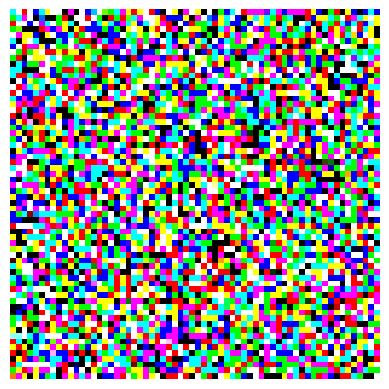

In [12]:
reverse_diffusion(model,30)

Total parameters:  62222764


Epoch 1: 100%|██████████████| 1624/1624 [12:18<00:00,  2.20 steps/s, loss=0.178]


2024-04-16 08:30:37.419310 Epoch 1, Training loss 0.22646315666345448


Epoch 2: 100%|██████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.211]


2024-04-16 08:42:49.417811 Epoch 2, Training loss 0.19763475403418906


Epoch 3: 100%|██████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.192]


2024-04-16 08:55:03.856360 Epoch 3, Training loss 0.19200930643081665


Epoch 4: 100%|██████████████| 1624/1624 [12:25<00:00,  2.18 steps/s, loss=0.189]


2024-04-16 09:07:29.836098 Epoch 4, Training loss 0.18904356422791113


Epoch 5: 100%|██████████████| 1624/1624 [12:20<00:00,  2.19 steps/s, loss=0.193]


2024-04-16 09:19:51.295230 Epoch 5, Training loss 0.18691831287053914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

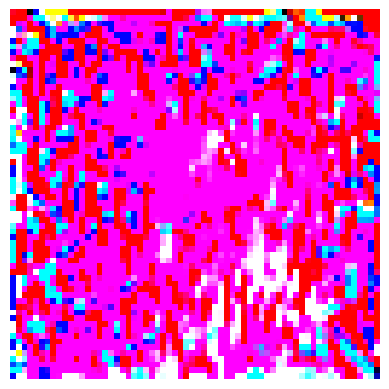

Epoch 6: 100%|██████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.173]


2024-04-16 09:32:09.370127 Epoch 6, Training loss 0.18536682713031769


Epoch 7: 100%|██████████████| 1624/1624 [12:19<00:00,  2.20 steps/s, loss=0.182]


2024-04-16 09:44:30.019618 Epoch 7, Training loss 0.1839250520009261


Epoch 8: 100%|██████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.168]


2024-04-16 09:56:44.372997 Epoch 8, Training loss 0.18293299958339104


Epoch 9: 100%|███████████████| 1624/1624 [12:06<00:00,  2.23 steps/s, loss=0.18]


2024-04-16 10:08:52.265344 Epoch 9, Training loss 0.1819905089690135


Epoch 10: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.164]


2024-04-16 10:21:07.294201 Epoch 10, Training loss 0.1808895201407946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

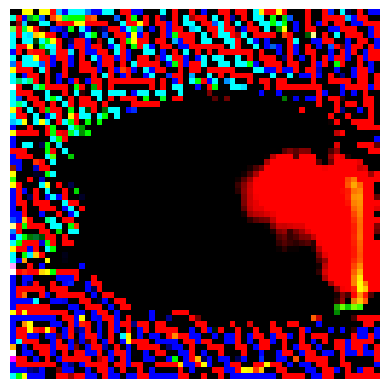

Epoch 11: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.176]


2024-04-16 10:33:26.780126 Epoch 11, Training loss 0.18038634950381058


Epoch 12: 100%|█████████████| 1624/1624 [12:19<00:00,  2.20 steps/s, loss=0.182]


2024-04-16 10:45:47.524656 Epoch 12, Training loss 0.179731079853498


Epoch 13: 100%|██████████████| 1624/1624 [12:05<00:00,  2.24 steps/s, loss=0.18]


2024-04-16 10:57:53.777681 Epoch 13, Training loss 0.1790885584262701


Epoch 14: 100%|█████████████| 1624/1624 [12:18<00:00,  2.20 steps/s, loss=0.194]


2024-04-16 11:10:12.930035 Epoch 14, Training loss 0.17849731446229494


Epoch 15: 100%|█████████████| 1624/1624 [12:06<00:00,  2.24 steps/s, loss=0.183]


2024-04-16 11:22:20.393129 Epoch 15, Training loss 0.1779517867748554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

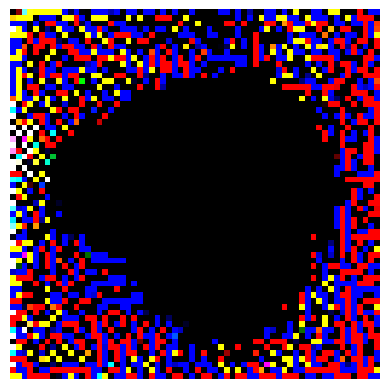

Epoch 16: 100%|██████████████| 1624/1624 [12:10<00:00,  2.22 steps/s, loss=0.17]


2024-04-16 11:34:41.030508 Epoch 16, Training loss 0.1774709681364206


Epoch 17: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.176]


2024-04-16 11:46:50.729058 Epoch 17, Training loss 0.1770050920889928


Epoch 18: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.159]


2024-04-16 11:58:59.698387 Epoch 18, Training loss 0.1765749844954564


Epoch 19: 100%|██████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.16]


2024-04-16 12:11:08.840346 Epoch 19, Training loss 0.17627521518560557


Epoch 20: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.175]


2024-04-16 12:23:18.359152 Epoch 20, Training loss 0.17582754615636972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

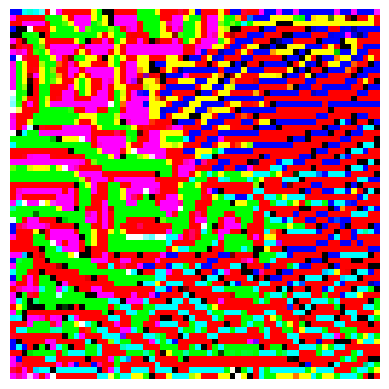

Epoch 21: 100%|█████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.179]


2024-04-16 12:35:42.651646 Epoch 21, Training loss 0.17543282332787147


Epoch 22: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.182]


2024-04-16 12:47:51.999571 Epoch 22, Training loss 0.17507244265996494


Epoch 23: 100%|█████████████| 1624/1624 [12:06<00:00,  2.23 steps/s, loss=0.203]


2024-04-16 12:59:59.589681 Epoch 23, Training loss 0.17470174892132098


Epoch 24: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.178]


2024-04-16 13:12:09.251440 Epoch 24, Training loss 0.1744772416628324


Epoch 25: 100%|█████████████| 1624/1624 [12:21<00:00,  2.19 steps/s, loss=0.181]


2024-04-16 13:24:32.170344 Epoch 25, Training loss 0.17408251410264236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

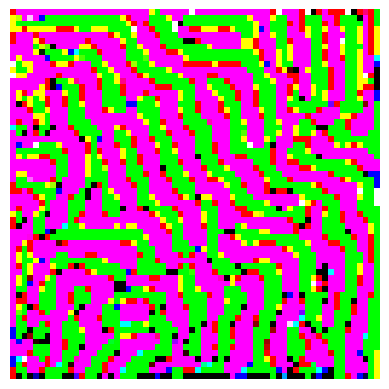

Epoch 26: 100%|█████████████| 1624/1624 [12:16<00:00,  2.20 steps/s, loss=0.177]


2024-04-16 13:36:58.842756 Epoch 26, Training loss 0.17363682023378518


Epoch 27: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.151]


2024-04-16 13:49:12.625270 Epoch 27, Training loss 0.173450708930309


Epoch 28: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.164]


2024-04-16 14:01:24.593464 Epoch 28, Training loss 0.17312140705952278


Epoch 29: 100%|██████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.17]


2024-04-16 14:13:37.923529 Epoch 29, Training loss 0.1729013972557508


Epoch 30: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.162]


2024-04-16 14:25:51.105882 Epoch 30, Training loss 0.17242259825192965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

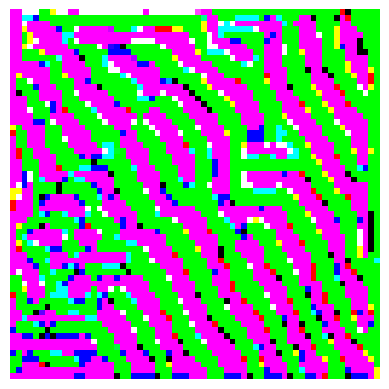

Epoch 31: 100%|█████████████| 1624/1624 [12:17<00:00,  2.20 steps/s, loss=0.169]


2024-04-16 14:38:18.123207 Epoch 31, Training loss 0.17224444251794083


Epoch 32: 100%|█████████████| 1624/1624 [12:09<00:00,  2.22 steps/s, loss=0.187]


2024-04-16 14:50:28.989831 Epoch 32, Training loss 0.1720003440288397


Epoch 33: 100%|█████████████| 1624/1624 [12:19<00:00,  2.20 steps/s, loss=0.167]


2024-04-16 15:02:48.942771 Epoch 33, Training loss 0.17168388362114245


Epoch 34: 100%|█████████████| 1624/1624 [12:17<00:00,  2.20 steps/s, loss=0.169]


2024-04-16 15:15:06.960546 Epoch 34, Training loss 0.1714642721231167


Epoch 35: 100%|█████████████| 1624/1624 [12:19<00:00,  2.19 steps/s, loss=0.168]


2024-04-16 15:27:27.844176 Epoch 35, Training loss 0.1710086473960143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

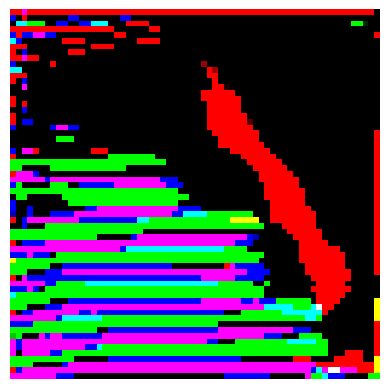

Epoch 36: 100%|█████████████| 1624/1624 [12:23<00:00,  2.18 steps/s, loss=0.168]


2024-04-16 15:40:01.441427 Epoch 36, Training loss 0.17076276660882508


Epoch 37: 100%|█████████████| 1624/1624 [12:19<00:00,  2.20 steps/s, loss=0.163]


2024-04-16 15:52:22.140550 Epoch 37, Training loss 0.170333664224698


Epoch 38: 100%|█████████████| 1624/1624 [12:20<00:00,  2.19 steps/s, loss=0.163]


2024-04-16 16:04:43.871181 Epoch 38, Training loss 0.17022667556542617


Epoch 39: 100%|█████████████| 1624/1624 [12:20<00:00,  2.19 steps/s, loss=0.176]


2024-04-16 16:17:04.942128 Epoch 39, Training loss 0.16981327052299794


Epoch 40: 100%|█████████████| 1624/1624 [12:18<00:00,  2.20 steps/s, loss=0.177]


2024-04-16 16:29:24.005675 Epoch 40, Training loss 0.1695852841780736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

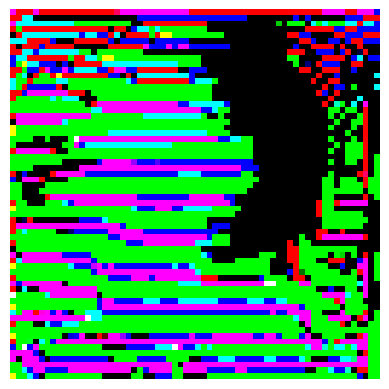

Epoch 41: 100%|█████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.181]


2024-04-16 16:41:47.628600 Epoch 41, Training loss 0.16929447044776036


Epoch 42: 100%|█████████████| 1624/1624 [54:50<00:00,  2.03s/ steps, loss=0.167]


2024-04-16 17:36:38.799758 Epoch 42, Training loss 0.16894674855929154


Epoch 43: 100%|████████████| 1624/1624 [2:08:00<00:00,  4.73s/ steps, loss=0.18]


2024-04-16 19:44:40.542557 Epoch 43, Training loss 0.16877570989498725


Epoch 44: 100%|█████████████| 1624/1624 [42:51<00:00,  1.58s/ steps, loss=0.171]


2024-04-16 20:27:33.114685 Epoch 44, Training loss 0.16843875792393317


Epoch 45: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.181]


2024-04-16 20:39:46.638732 Epoch 45, Training loss 0.16804682998473827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

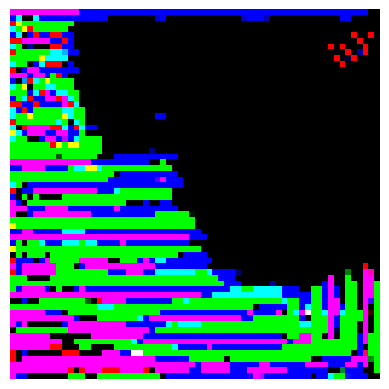

Epoch 46: 100%|█████████████| 1624/1624 [12:20<00:00,  2.19 steps/s, loss=0.154]


2024-04-16 20:52:16.787127 Epoch 46, Training loss 0.16774348380015447


Epoch 47: 100%|█████████████| 1624/1624 [12:31<00:00,  2.16 steps/s, loss=0.159]


2024-04-16 21:04:49.538674 Epoch 47, Training loss 0.16755759625251476


Epoch 48: 100%|█████████████| 1624/1624 [12:17<00:00,  2.20 steps/s, loss=0.161]


2024-04-16 21:17:07.473785 Epoch 48, Training loss 0.16722717971068163


Epoch 49: 100%|██████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.17]


2024-04-16 21:29:17.701406 Epoch 49, Training loss 0.16701840783999516


Epoch 50: 100%|█████████████| 1624/1624 [12:17<00:00,  2.20 steps/s, loss=0.167]


2024-04-16 21:41:35.892683 Epoch 50, Training loss 0.16670255078719212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

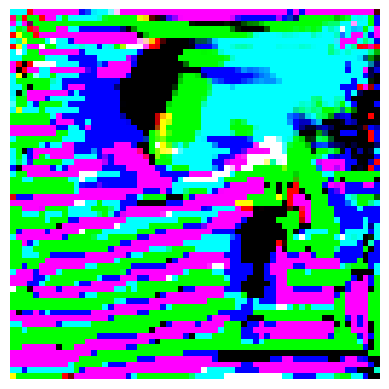

Epoch 51: 100%|█████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.162]


2024-04-16 21:54:00.255600 Epoch 51, Training loss 0.16639320021409254


Epoch 52: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.156]


2024-04-16 22:06:13.415486 Epoch 52, Training loss 0.1660453370992954


Epoch 53: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.178]


2024-04-16 22:18:28.344934 Epoch 53, Training loss 0.16579021356656


Epoch 54: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.157]


2024-04-16 22:30:41.991628 Epoch 54, Training loss 0.1654860318348958


Epoch 55: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.161]


2024-04-16 22:42:56.237534 Epoch 55, Training loss 0.16518707211201009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

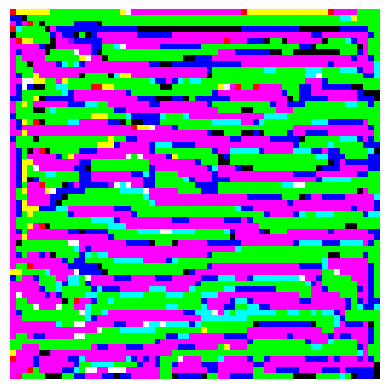

Epoch 56: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.155]


2024-04-16 22:55:19.354841 Epoch 56, Training loss 0.16484862404603223


Epoch 57: 100%|█████████████| 1624/1624 [12:13<00:00,  2.22 steps/s, loss=0.159]


2024-04-16 23:07:33.396200 Epoch 57, Training loss 0.16462185309483454


Epoch 58: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.167]


2024-04-16 23:19:47.530195 Epoch 58, Training loss 0.1644364949923295


Epoch 59: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.172]


2024-04-16 23:32:02.183540 Epoch 59, Training loss 0.1640282515654197


Epoch 60: 100%|█████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.154]


2024-04-16 23:44:17.210273 Epoch 60, Training loss 0.16376181690509503


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

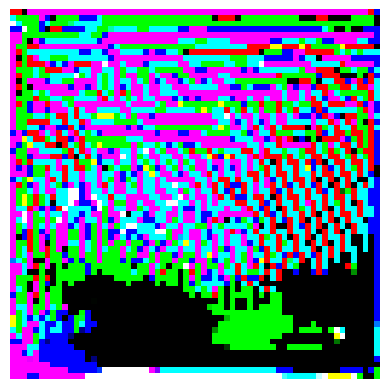

Epoch 61: 100%|█████████████| 1624/1624 [12:13<00:00,  2.21 steps/s, loss=0.159]


2024-04-16 23:56:40.062661 Epoch 61, Training loss 0.1633721571793923


Epoch 62: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.155]


2024-04-17 00:08:52.288517 Epoch 62, Training loss 0.16323545342225296


Epoch 63: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.166]


2024-04-17 00:21:02.861573 Epoch 63, Training loss 0.16282205011294437


Epoch 64: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.159]


2024-04-17 00:33:12.962585 Epoch 64, Training loss 0.16256107897941882


Epoch 65: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.147]


2024-04-17 00:45:23.042799 Epoch 65, Training loss 0.16213558661937713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

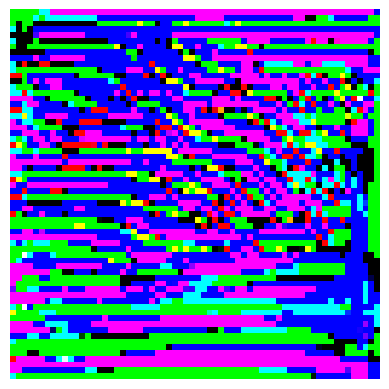

Epoch 66: 100%|█████████████| 1624/1624 [12:10<00:00,  2.22 steps/s, loss=0.164]


2024-04-17 00:57:42.701679 Epoch 66, Training loss 0.16184105338500096


Epoch 67: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.158]


2024-04-17 01:09:53.243049 Epoch 67, Training loss 0.16153498268127442


Epoch 68: 100%|█████████████| 1624/1624 [12:10<00:00,  2.22 steps/s, loss=0.161]


2024-04-17 01:22:04.665666 Epoch 68, Training loss 0.1612391140644367


Epoch 69: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.176]


2024-04-17 01:34:17.368972 Epoch 69, Training loss 0.16101159227811374


Epoch 70: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.161]


2024-04-17 01:46:26.486084 Epoch 70, Training loss 0.16072697666058172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

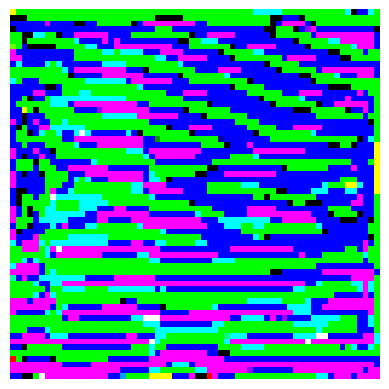

Epoch 71: 100%|█████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.152]


2024-04-17 01:58:43.564661 Epoch 71, Training loss 0.16050347883884725


Epoch 72: 100%|█████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.156]


2024-04-17 02:10:51.846232 Epoch 72, Training loss 0.1600231681053455


Epoch 73: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.167]


2024-04-17 02:23:00.926693 Epoch 73, Training loss 0.15984057299907392


Epoch 74: 100%|█████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.153]


2024-04-17 02:35:08.885532 Epoch 74, Training loss 0.1595582686846073


Epoch 75: 100%|█████████████| 1624/1624 [12:09<00:00,  2.23 steps/s, loss=0.155]


2024-04-17 02:47:19.015901 Epoch 75, Training loss 0.1593004491145794


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

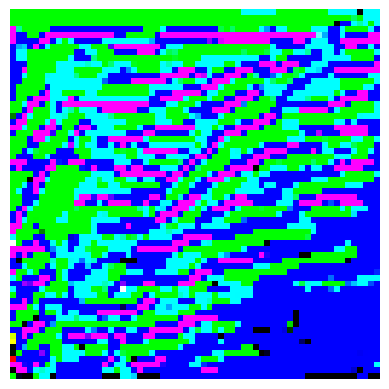

Epoch 76: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.165]


2024-04-17 02:59:40.773578 Epoch 76, Training loss 0.1589509460742657


Epoch 77: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.151]


2024-04-17 03:11:53.782504 Epoch 77, Training loss 0.15866049251189598


Epoch 78: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.162]


2024-04-17 03:24:07.262577 Epoch 78, Training loss 0.15830745570476237


Epoch 79: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.149]


2024-04-17 03:36:20.567154 Epoch 79, Training loss 0.15802600772564226


Epoch 80: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.174]


2024-04-17 03:48:33.821742 Epoch 80, Training loss 0.15778134174530323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

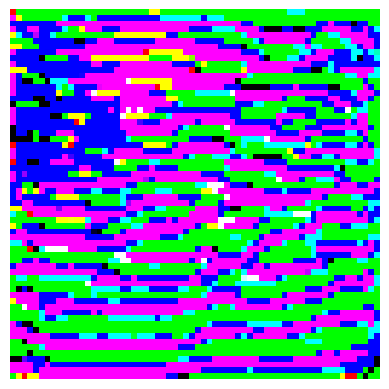

Epoch 81: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.153]


2024-04-17 04:00:55.407468 Epoch 81, Training loss 0.15748720511106346


Epoch 82: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.155]


2024-04-17 04:13:07.976805 Epoch 82, Training loss 0.1569857808443216


Epoch 83: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.157]


2024-04-17 04:25:20.682811 Epoch 83, Training loss 0.1568737962796138


Epoch 84: 100%|██████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.15]


2024-04-17 04:37:33.271297 Epoch 84, Training loss 0.15653738009929657


Epoch 85: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.163]


2024-04-17 04:49:46.315779 Epoch 85, Training loss 0.15615743114398076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

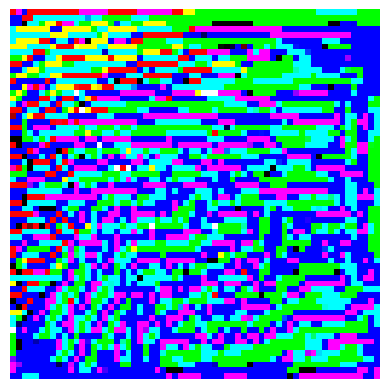

Epoch 86: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.149]


2024-04-17 05:02:07.507214 Epoch 86, Training loss 0.15586952876127683


Epoch 87: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.152]


2024-04-17 05:14:19.590732 Epoch 87, Training loss 0.15567728314032922


Epoch 88: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.146]


2024-04-17 05:26:31.868374 Epoch 88, Training loss 0.15535725361567276


Epoch 89: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.165]


2024-04-17 05:38:43.892557 Epoch 89, Training loss 0.1549847309772785


Epoch 90: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.141]


2024-04-17 05:50:56.652527 Epoch 90, Training loss 0.15465304486568157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

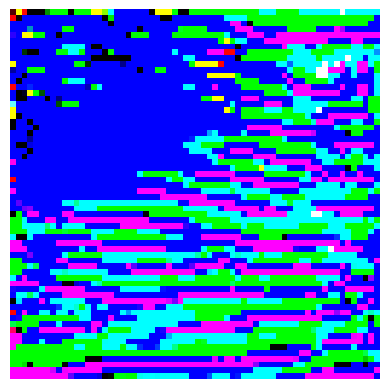

Epoch 91: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.151]


2024-04-17 06:03:18.641871 Epoch 91, Training loss 0.1544121277332306


Epoch 92: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.164]


2024-04-17 06:15:31.770862 Epoch 92, Training loss 0.1540864897966385


Epoch 93: 100%|█████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.165]


2024-04-17 06:27:44.421406 Epoch 93, Training loss 0.1539847119954916


Epoch 94: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.168]


2024-04-17 06:39:57.519368 Epoch 94, Training loss 0.15350899635828458


Epoch 95: 100%|██████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.15]


2024-04-17 06:52:10.368893 Epoch 95, Training loss 0.1531963360951497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

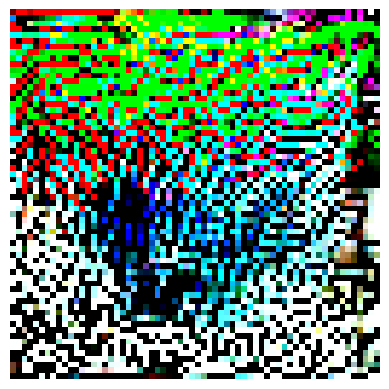

Epoch 96: 100%|█████████████| 1624/1624 [12:08<00:00,  2.23 steps/s, loss=0.142]


2024-04-17 07:04:29.005928 Epoch 96, Training loss 0.15311660289764403


Epoch 97: 100%|█████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.143]


2024-04-17 07:16:37.500774 Epoch 97, Training loss 0.15273794508897343


Epoch 98: 100%|█████████████| 1624/1624 [12:26<00:00,  2.18 steps/s, loss=0.164]


2024-04-17 07:29:04.394308 Epoch 98, Training loss 0.15253383363210238


Epoch 99: 100%|█████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.152]


2024-04-17 07:41:17.499629 Epoch 99, Training loss 0.15197836736532358


Epoch 100: 100%|████████████| 1624/1624 [12:12<00:00,  2.22 steps/s, loss=0.152]


2024-04-17 07:53:30.850433 Epoch 100, Training loss 0.15175981727930216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

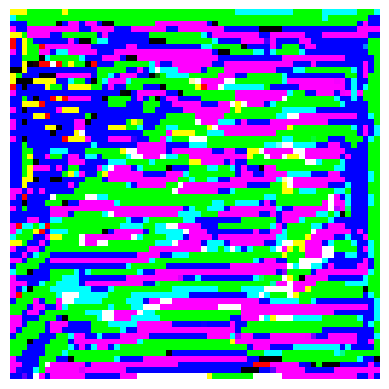

Epoch 101: 100%|████████████| 1624/1624 [12:16<00:00,  2.20 steps/s, loss=0.161]


2024-04-17 08:05:57.400113 Epoch 101, Training loss 0.15134499775446378


Epoch 102: 100%|████████████| 1624/1624 [12:15<00:00,  2.21 steps/s, loss=0.164]


2024-04-17 08:18:14.158790 Epoch 102, Training loss 0.151135294006421


Epoch 103: 100%|████████████| 1624/1624 [12:20<00:00,  2.19 steps/s, loss=0.154]


2024-04-17 08:30:35.687929 Epoch 103, Training loss 0.1509453298862164


Epoch 104: 100%|████████████| 1624/1624 [12:17<00:00,  2.20 steps/s, loss=0.141]


2024-04-17 08:42:54.120865 Epoch 104, Training loss 0.1506926421752343


Epoch 105: 100%|████████████| 1624/1624 [12:22<00:00,  2.19 steps/s, loss=0.161]


2024-04-17 08:55:18.001551 Epoch 105, Training loss 0.1504014949615185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

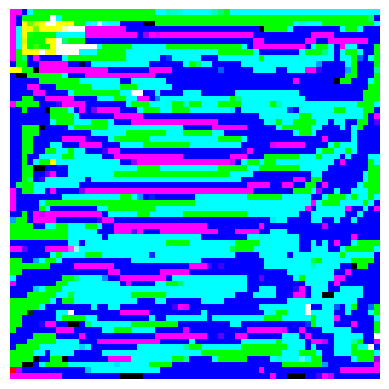

Epoch 106: 100%|████████████| 1624/1624 [12:22<00:00,  2.19 steps/s, loss=0.146]


2024-04-17 09:07:50.435520 Epoch 106, Training loss 0.15008869431569027


Epoch 107: 100%|████████████| 1624/1624 [12:16<00:00,  2.20 steps/s, loss=0.153]


2024-04-17 09:20:08.281951 Epoch 107, Training loss 0.14977239760985742


Epoch 108: 100%|████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.162]


2024-04-17 09:32:23.291106 Epoch 108, Training loss 0.14957623925575844


Epoch 109: 100%|████████████| 1624/1624 [12:16<00:00,  2.21 steps/s, loss=0.151]


2024-04-17 09:44:40.302608 Epoch 109, Training loss 0.14907474653537456


Epoch 110: 100%|████████████| 1624/1624 [12:18<00:00,  2.20 steps/s, loss=0.148]


2024-04-17 09:56:59.421230 Epoch 110, Training loss 0.14893087028540097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

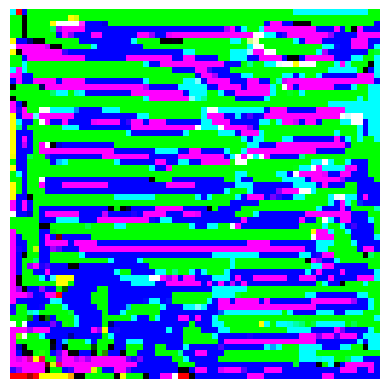

Epoch 111: 100%|████████████| 1624/1624 [12:19<00:00,  2.20 steps/s, loss=0.147]


2024-04-17 10:09:29.102829 Epoch 111, Training loss 0.1486847153535256


Epoch 112: 100%|████████████| 1624/1624 [12:16<00:00,  2.21 steps/s, loss=0.154]


2024-04-17 10:21:46.261996 Epoch 112, Training loss 0.14849553102254867


Epoch 113: 100%|████████████| 1624/1624 [12:14<00:00,  2.21 steps/s, loss=0.142]


2024-04-17 10:34:02.159789 Epoch 113, Training loss 0.14819702204832663


Epoch 114: 100%|████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.169]


2024-04-17 10:46:14.600098 Epoch 114, Training loss 0.14781346460030628


Epoch 115: 100%|████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.155]


2024-04-17 10:58:26.938404 Epoch 115, Training loss 0.14748404378157395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

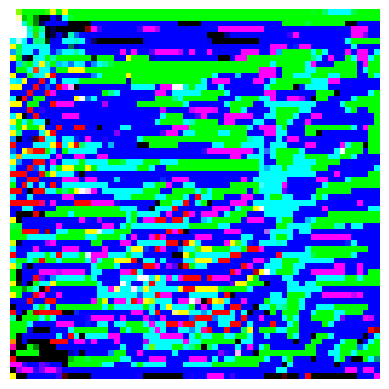

Epoch 116: 100%|████████████| 1624/1624 [12:11<00:00,  2.22 steps/s, loss=0.139]


2024-04-17 11:10:47.993187 Epoch 116, Training loss 0.14726605276878063


Epoch 117: 100%|████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.141]


2024-04-17 11:22:56.171138 Epoch 117, Training loss 0.14712885985007654


Epoch 118: 100%|████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.145]


2024-04-17 11:35:04.767106 Epoch 118, Training loss 0.14676756260028254


Epoch 119: 100%|████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.142]


2024-04-17 11:47:13.302819 Epoch 119, Training loss 0.14655455571871537


Epoch 120: 100%|█████████████| 1624/1624 [12:07<00:00,  2.23 steps/s, loss=0.15]


2024-04-17 11:59:21.811263 Epoch 120, Training loss 0.14633020410170922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

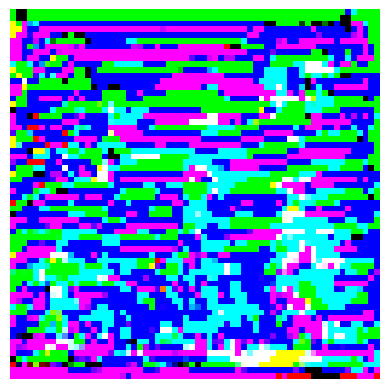

Epoch 121:  99%|███████████▉| 1610/1624 [12:01<00:06,  2.24 steps/s, loss=0.142]

In [ ]:
print("Total parameters: ",count_parameters(model))
loss_fn = nn.MSELoss()  #  <4>
#loss_fn = nn.L1Loss()

training_loop(  # <5>
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    batch_size = 16,
    epoch_start = 1,
    timesteps = timesteps
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


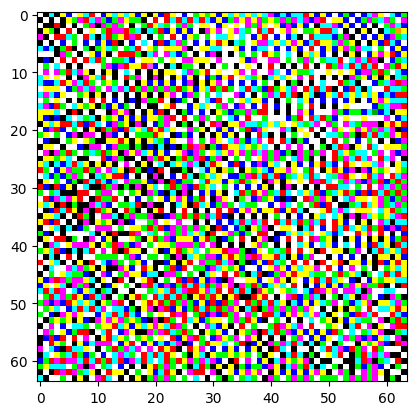

In [13]:
inference(model, device)

In [ ]:
x_0 = torch.rand(10,3,128,128).numpy()
t = torch.range(1,10)
print(t.shape)
sg, ns = forward_noise(0,x_0,t)
print(sg.shape)
print(ns.shape)